In [687]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
import os
import zipfile
import warnings
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from nltk.corpus import stopwords
warnings.filterwarnings('ignore')
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [310]:
zf = zipfile.ZipFile('../data/pos.zip')
zf1 = zipfile.ZipFile('../data/neg.zip')
col_names=['FileName','Content','Reviews']
text_df_pos=pd.DataFrame(columns = col_names)
text_df_neg=pd.DataFrame(columns = col_names)
j=0
for file in zf.namelist():
    text_string=""
    if ".txt" in file:
        df = pd.read_csv(zf.open(file),sep='\t',error_bad_lines=False,header=None)
        for i in range(len(df)):
            text_string+=df[0][i]
        text_string = re.sub('\W+',' ', text_string )  #remove punctuation
        text_string = ''.join([i for i in text_string if not i.isdigit()]) # remove numbers
        text_df_pos.loc[j]=[file,text_string,1]
        j+=1
        
j=0
for file in zf1.namelist():
    text_string=""
    if ".txt" in file:
        df = pd.read_csv(zf1.open(file),sep='\t',error_bad_lines=False,header=None)
        for i in range(len(df)):
            text_string+=df[0][i]
        text_string = re.sub('\W+',' ', text_string ) #remove punctuation
        text_string = ''.join([i for i in text_string if not i.isdigit()]) # remove numbers
        text_df_neg.loc[j]=[file,text_string,0]
        j+=1

In [311]:
text_df_pos.head()

,FileName,Content,Reviews
0,cv007_4968.txt,one of my colleagues was surprised when i told...,1
1,cv289_6463.txt,note that followups are directed to rec arts ...,1
2,cv344_5312.txt,do you want to know the truth about cats and d...,1
3,cv403_6621.txt,my fellow americans is a movie that at first g...,1
4,cv626_7410.txt,this reviewer is ignorant of what hands were r...,1


In [312]:
text_df_neg.head()

,FileName,Content,Reviews
0,cv258_5627.txt,the army comedy genre has never turned out a t...,0
1,cv754_7709.txt,capsule godawful comedy that s amazingly shabb...,0
2,cv007_4992.txt,that s exactly how long the movie felt to me t...,0
3,cv016_4348.txt,i m really starting to wonder about alicia sil...,0
4,cv020_9234.txt,spawn features good guys bad guys lots of fig...,0


In [313]:
training_data=pd.DataFrame(columns = col_names)
testing_data=pd.DataFrame(columns = col_names)
for i in range(len(text_df_pos)):
    file=text_df_pos['FileName'][i].split('_')[0]
    file_num=file[len(file)-3:len(file)]
    if int(file_num) >=0 and int(file_num)<=699:  #  Use text files 0-699 in each class for training
        training_data.loc[i]=[text_df_pos['FileName'][i],text_df_pos['Content'][i].strip('  '),1]
    else:
        testing_data.loc[i]=[text_df_pos['FileName'][i],text_df_pos['Content'][i].strip('  '),1]

for j in range(len(text_df_neg)):
    file=text_df_neg['FileName'][j].split('_')[0]
    file_num=file[len(file)-3:len(file)]
    if int(file_num) >=0 and int(file_num)<=699:  #  Use text files 0-699 in each class for training
        training_data.loc[i]=[text_df_neg['FileName'][j],text_df_neg['Content'][j].strip('  '),0]
    else:
        testing_data.loc[i]=[text_df_neg['FileName'][j],text_df_neg['Content'][j].strip('  '),0]
    i+=1
    

In [314]:
len(training_data)

1400

In [315]:
len(testing_data)

600

#### Count the number of unique words in the whole dataset (train + test) and print it out.

In [669]:
total_data=pd.concat([training_data,testing_data],ignore_index=True)
total_words=""
for i in range(len(total_data)):
    text=total_data['Content'][i]
    if total_words=="":
        total_words += text
    else:
        total_words = total_words + " " + text

print ("Number of unique words in the whole dataset: "+str(len(set(total_words.split(' ')))))
print ("\n")
print ("-------Unique words-----\n")
for val in set(total_words.split(' ')):
    print (val)

Number of unique words in the whole dataset: 39212


-------Unique words-----


hugging
spotting
poor
projector
dr
proffered
penciller
dispassionate
barbarity
hatchette
dialog
danna
blanchett
belfast
storywise
ushered
amaze
contraception
halfway
sauna
umu
kuo
pricelessly
suggests
retake
supplied
abiility
brautigan
liking
concerto
rob
disgustingly
identification
choreographed
updating
scintilla
rejuvenating
doorways
punctuated
opning
dub
appropriate
budget
goer
perky
bellylaughs
rue
gantry
warlock
sadistic
marla
judson
crocheting
wholesome
sarita
ability
aatish
disrespect
afoot
_come_
perpretrators
additional
college
perez
yearbook
untapped
iniquity
jello
beds
pooper
chronically
kaela
oppposed
recalled
slices
identifiable
execrable
steadily
licia
petievich
wingers
overwritten
bank
mccamus
equals
nominated
edvard
wristwatch
chad
sam
aide
mysteriously
wedding
army
simplicity
milagro
wayward
hart
hipper
unfrozen
departing
unheralded
redux
excusing
partakes
procreating
victor
elizabethan
le

#### Calculate the average review length and the standard deviation of review lengths. Report the results

In [670]:
review_length=0
review_length_lst=[]
for i in range(len(total_data)):
    review_length_lst.append(len(total_data['Content'][i].split(' ')))
    review_length+=len(total_data['Content'][i].split(' '))

print ("Average Review Length: "+str(review_length/2000))
print ("-------------")
print ("Std Dev of review lengths: "+str(statistics.stdev(review_length_lst)))

Average Review Length: 668.3185
-------------
Std Dev of review lengths: 294.62760014827967


#### Plot the histogram of review lengths.

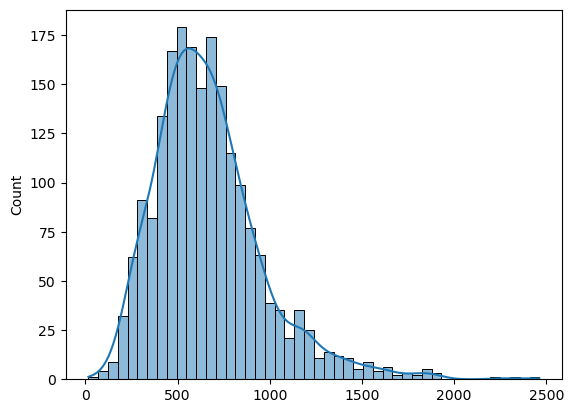

In [672]:
arr = np.array(review_length_lst)
sns.histplot(data=arr,kde=True)
plt.show()

#### Performing Other data processing techniques such as removing stop words, stemming, lemmatization, etc

In [691]:
# Removing Stop Words

for i in range(len(total_data)):
    new_text=""
    text=total_data['Content'][i]
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    new_text=" ".join(str(x) for x in filtered_sentence)
    total_data['Content'][i]=new_text
total_data.head()

,FileName,Content,Reviews
0,cv007_4968.txt,one colleagues surprised told willing see bets...,1
1,cv289_6463.txt,note followups directed rec arts movies curren...,1
2,cv344_5312.txt,want know truth cats dogs well movie shows us ...,1
3,cv403_6621.txt,fellow americans movie first glance looks litt...,1
4,cv626_7410.txt,reviewer ignorant hands responsible delivering...,1


#### Tokenization

In [692]:
total_words=""
lst=[]
for i in range(len(total_data)):
    text=total_data['Content'][i]
    lst.append(text)
    if total_words=="":
        total_words += text
    else:
        total_words = total_words + " " + text
t = Tokenizer(num_words=5000)
t.fit_on_texts([total_words]) #fitting on the enitre data
token_lst=[]
sentiment_lst=[]
reviews_lst=[]
file_name_lst=[]
for i in range(len(total_data)):
    token_lst.append(t.texts_to_sequences([total_data['Content'][i]])[0])
    sentiment_lst.append(total_data['Reviews'][i])
    reviews_lst.append(total_data['Content'][i])
    file_name_lst.append(total_data['FileName'][i])
    #total_data['Token_Seq'][i]=t.texts_to_sequences([total_data['Content'][i]])
   


In [693]:
print (len(file_name_lst))

2000


#### Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [694]:
word_len=[]
for i in range(len(total_data)):
    word_len.append(len(total_data['Content'][i].split(' '))) #ith doc and its number of words

word_len.sort()
L=word_len[1401]
    
print ("Value of L: "+str(L))
count=0
for val in word_len:
    if val < L:
        count+=1
print ("Percentage of reviews with length < L: "+ str(count/2000))

Value of L: 402
Percentage of reviews with length < L: 0.7


#### Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L

In [695]:
pad_tokens_lst=pad_sequences(token_lst, maxlen=L)      

In [696]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
for i in range(len(pad_tokens_lst)):
    file=file_name_lst[i].split('_')[0]
    file_num=file[len(file)-3:len(file)]
    if int(file_num) >=0 and int(file_num)<=699:  #  Use text files 0-699 in each class for training
        X_train.append(pad_tokens_lst[i])
        y_train.append(sentiment_lst[i])
    else:
        X_test.append(pad_tokens_lst[i])
        y_test.append(sentiment_lst[i])

#### Word Embeddings

In [714]:
model = Sequential()
model.add(Embedding(5000, 32, input_length=L))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_79 (Embedding)    (None, 402, 32)           160000    
                                                                 
 flatten_64 (Flatten)        (None, 12864)             0         
                                                                 
 dense_232 (Dense)           (None, 1)                 12865     
                                                                 
Total params: 172,865
Trainable params: 172,865
Non-trainable params: 0
_________________________________________________________________
None


In [715]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)
model.fit(X_train, y_train, validation_split=0.2,epochs=100, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print('Train Accuracy: %f' % (accuracy*100))

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))

Train Accuracy: 90.071428
Test Accuracy: 75.666666


#### Multi-Layer Perceptron

In [716]:
model = Sequential()
model.add(Embedding(5000, 32, input_length=L))
model.add(Flatten())
model.add(Dense(50, input_dim=L))
model.add(Activation('relu'))
model.add(Dropout(0.20))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.50))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.50))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [717]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [734]:
#model = keras.models.load_model('../data/finalized_MLP.zip')
model.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=0.2,callbacks=[early_stopping_monitor])

Epoch 1/2
112/112 [==============================] - 1s 12ms/step - loss: 1.2509e-04 - accuracy: 1.0000 - val_loss: 4.0657 - val_accuracy: 0.4571
Epoch 2/2
112/112 [==============================] - 1s 11ms/step - loss: 3.4634e-04 - accuracy: 1.0000 - val_loss: 3.9225 - val_accuracy: 0.5107


In [418]:
# model.save('../data/finalized_MLP.zip')

In [735]:
loss, accuracy = model.evaluate(X_train,  y_train, verbose = 0)
print('Train Accuracy: %f' % (accuracy*100))
loss, accuracy = model.evaluate(X_test,  y_test, verbose = 0)
print('Test Accuracy: %f' % (accuracy*100))

Train Accuracy: 90.214288
Test Accuracy: 66.500002


#### Looking at above we cay say that train accuracy is around 90 percent in 2 epochs and test accuracy is 66.5 % in 2 epochs

#### After increasing epochs

In [738]:
model = Sequential()
model.add(Embedding(5000, 32, input_length=L))
model.add(Flatten())
model.add(Dense(50, input_dim=L))
model.add(Activation('relu'))
model.add(Dropout(0.20))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.50))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.50))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [739]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=25,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [748]:
#model = keras.models.load_model('../data/finalized_MLP.zip')
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2,callbacks=[early_stopping_monitor])

Epoch 1/50
112/112 [==============================] - 1s 12ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 2.5677 - val_accuracy: 0.5964
Epoch 2/50
112/112 [==============================] - 1s 12ms/step - loss: 9.7773e-04 - accuracy: 1.0000 - val_loss: 2.9677 - val_accuracy: 0.6000
Epoch 3/50
112/112 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9991 - val_loss: 3.9602 - val_accuracy: 0.5214
Epoch 4/50
112/112 [==============================] - 1s 12ms/step - loss: 3.9595e-04 - accuracy: 1.0000 - val_loss: 3.9436 - val_accuracy: 0.5357
Epoch 5/50
112/112 [==============================] - 1s 12ms/step - loss: 0.0011 - accuracy: 0.9991 - val_loss: 3.4067 - val_accuracy: 0.5893
Epoch 6/50
112/112 [==============================] - 1s 12ms/step - loss: 1.1861e-04 - accuracy: 1.0000 - val_loss: 3.4174 - val_accuracy: 0.5857
Epoch 7/50
112/112 [==============================] - 1s 12ms/step - loss: 4.8031e-05 - accuracy: 1.0000 - val_loss: 3.5133 - val_

In [749]:
loss, accuracy = model.evaluate(X_train,  y_train, verbose = 0)
print('Train Accuracy: %f' % (accuracy*100))
loss, accuracy = model.evaluate(X_test,  y_test, verbose = 0)
print('Test Accuracy: %f' % (accuracy*100))

Train Accuracy: 91.928571
Test Accuracy: 72.833335


#### We can see that the train accuracy has increased from 90% to 91% and the test accuracy has increased from 66 percent to 72 percent after increasing epochs and using early stopping

#### One-Dimensional Convolutional Neural Network:

In [752]:
model_conv = Sequential()
model_conv.add(Embedding(5000, 32, input_length=L))
model_conv.add(Conv1D(32, 3, activation='relu', input_shape=(None,L,1)))
model_conv.add(MaxPooling1D(pool_size=2,strides=2))
model_conv.add(Flatten())
model_conv.add(Dense(50, input_dim=L))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.20))
model_conv.add(Dense(50))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.50))
model_conv.add(Dense(50))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.50))
model_conv.add(Dense(1))
model_conv.add(Activation('sigmoid'))
model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_83 (Embedding)    (None, 402, 32)           160000    
                                                                 
 conv1d_26 (Conv1D)          (None, 400, 32)           3104      
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 200, 32)          0         
 g1D)                                                            
                                                                 
 flatten_68 (Flatten)        (None, 6400)              0         
                                                                 
 dense_245 (Dense)           (None, 50)                320050    
                                                                 
 activation_227 (Activation)  (None, 50)               0         
                                                     

In [753]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

#### I am using early stopping here to make sure the best model weights are stored. Since the patience is 2, the model won't be stopped before 2 epochs

In [756]:
# model_conv = keras.models.load_model('../data/finalized_MLP.zip')
model_conv.fit(X_train, y_train, epochs=2, batch_size=10,validation_split=0.2,callbacks=[early_stopping_monitor])

Epoch 1/2
112/112 [==============================] - 2s 14ms/step - loss: 0.5126 - accuracy: 0.6402 - val_loss: 0.8514 - val_accuracy: 0.4786
Epoch 2/2
112/112 [==============================] - 2s 14ms/step - loss: 0.3064 - accuracy: 0.9375 - val_loss: 1.4701 - val_accuracy: 0.4714


In [757]:
loss, accuracy = model_conv.evaluate(X_train,  y_train, verbose = 0)
print('Train Accuracy: %f' % (accuracy*100))
loss, accuracy = model_conv.evaluate(X_test,  y_test, verbose = 0)
print('Test Accuracy: %f' % (accuracy*100))

Train Accuracy: 88.928574
Test Accuracy: 74.333334


#### After increasing epochs and using early stopping

In [760]:
model_conv = Sequential()
model_conv.add(Embedding(5000, 32, input_length=L))
model_conv.add(Conv1D(32, 3, activation='relu', input_shape=(None,L,1)))
model_conv.add(MaxPooling1D(pool_size=2,strides=2))
model_conv.add(Flatten())
model_conv.add(Dense(50, input_dim=L))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.20))
model_conv.add(Dense(50))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.50))
model_conv.add(Dense(50))
model_conv.add(Activation('relu'))
model_conv.add(Dropout(0.50))
model_conv.add(Dense(1))
model_conv.add(Activation('sigmoid'))
model_conv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_conv.summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_84 (Embedding)    (None, 402, 32)           160000    
                                                                 
 conv1d_27 (Conv1D)          (None, 400, 32)           3104      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 200, 32)          0         
 g1D)                                                            
                                                                 
 flatten_69 (Flatten)        (None, 6400)              0         
                                                                 
 dense_249 (Dense)           (None, 50)                320050    
                                                                 
 activation_231 (Activation)  (None, 50)               0         
                                                     

In [761]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [762]:
# model_conv = keras.models.load_model('../data/finalized_MLP.zip')
model_conv.fit(X_train, y_train, epochs=50, batch_size=10,validation_split=0.2,callbacks=[early_stopping_monitor])

Epoch 1/50
112/112 [==============================] - 2s 10ms/step - loss: 0.6713 - accuracy: 0.5946 - val_loss: 0.9361 - val_accuracy: 0.0000e+00
Epoch 2/50
112/112 [==============================] - 1s 10ms/step - loss: 0.6500 - accuracy: 0.6250 - val_loss: 1.0158 - val_accuracy: 0.0000e+00
Epoch 3/50
112/112 [==============================] - 1s 9ms/step - loss: 0.5195 - accuracy: 0.6714 - val_loss: 1.5138 - val_accuracy: 0.1464
Epoch 4/50
112/112 [==============================] - 1s 9ms/step - loss: 0.2785 - accuracy: 0.9411 - val_loss: 0.6930 - val_accuracy: 0.7821
Epoch 5/50
112/112 [==============================] - 1s 9ms/step - loss: 0.0883 - accuracy: 0.9937 - val_loss: 2.3692 - val_accuracy: 0.5214
Epoch 6/50
112/112 [==============================] - 1s 10ms/step - loss: 0.0277 - accuracy: 0.9955 - val_loss: 2.2189 - val_accuracy: 0.6036
Epoch 7/50
112/112 [==============================] - 1s 10ms/step - loss: 0.0407 - accuracy: 0.9902 - val_loss: 2.0329 - val_accuracy: 0

In [763]:
loss, accuracy = model_conv.evaluate(X_train,  y_train, verbose = 0)
print('Train Accuracy: %f' % (accuracy*100))
loss, accuracy = model_conv.evaluate(X_test,  y_test, verbose = 0)
print('Test Accuracy: %f' % (accuracy*100))

Train Accuracy: 95.142859
Test Accuracy: 80.666667


#### It can be seen that the train accuracy has increased from 88% to 95% with 50 epochs and early stopping. The test accuracy has increased from 74% to 80%.

#### Long Short-Term Memory Recurrent Neural Network:

In [768]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(5000, 32, input_length=L))
model_LSTM.add(LSTM(32,dropout=0.2,recurrent_dropout=0.2))
model_LSTM.add(Flatten())
model_LSTM.add(Dense(256))
model_LSTM.add(Activation('relu'))
model_LSTM.add(Dropout(0.20))
model_LSTM.add(Dense(1))
model_LSTM.add(Activation('sigmoid'))
from keras import optimizers
optimizer = tensorflow.optimizers.Adam(clipvalue=0.001)
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_86 (Embedding)    (None, 402, 32)           160000    
                                                                 
 lstm_30 (LSTM)              (None, 32)                8320      
                                                                 
 flatten_71 (Flatten)        (None, 32)                0         
                                                                 
 dense_255 (Dense)           (None, 256)               8448      
                                                                 
 activation_237 (Activation)  (None, 256)              0         
                                                                 
 dropout_176 (Dropout)       (None, 256)               0         
                                                                 
 dense_256 (Dense)           (None, 1)               

In [769]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=11,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

#### I have used early stopping after certain number of epochs to avoid overfit. The best model obtained and its weights are stored which are then used later on to find the test accuracy

In [791]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(5000, 32, input_length=L))
model_LSTM.add(LSTM(32,dropout=0.2,recurrent_dropout=0.2))
model_LSTM.add(Flatten())
model_LSTM.add(Dense(256))
model_LSTM.add(Activation('relu'))
model_LSTM.add(Dropout(0.20))
model_LSTM.add(Dense(1))
model_LSTM.add(Activation('sigmoid'))
from keras import optimizers
optimizer = tensorflow.optimizers.Adam(clipvalue=0.001)
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_91 (Embedding)    (None, 402, 32)           160000    
                                                                 
 lstm_35 (LSTM)              (None, 32)                8320      
                                                                 
 flatten_76 (Flatten)        (None, 32)                0         
                                                                 
 dense_265 (Dense)           (None, 256)               8448      
                                                                 
 activation_247 (Activation)  (None, 256)              0         
                                                                 
 dropout_181 (Dropout)       (None, 256)               0         
                                                                 
 dense_266 (Dense)           (None, 1)               

In [792]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=11,
    verbose=0,
    mode='auto',
    baseline=0.8,
    restore_best_weights=True
)

In [793]:
model_LSTM.fit(X_train, y_train, validation_split=0.2,epochs=13, batch_size=10,callbacks=[early_stopping_monitor])

Epoch 1/13
112/112 [==============================] - 41s 340ms/step - loss: 0.6603 - accuracy: 0.6179 - val_loss: 0.9985 - val_accuracy: 0.0000e+00
Epoch 2/13
112/112 [==============================] - 37s 327ms/step - loss: 0.3580 - accuracy: 0.8393 - val_loss: 1.0348 - val_accuracy: 0.5607
Epoch 3/13
112/112 [==============================] - 36s 326ms/step - loss: 0.0683 - accuracy: 0.9804 - val_loss: 0.6618 - val_accuracy: 0.7393
Epoch 4/13
112/112 [==============================] - 37s 331ms/step - loss: 0.0182 - accuracy: 0.9964 - val_loss: 1.5776 - val_accuracy: 0.6679
Epoch 5/13
112/112 [==============================] - 37s 326ms/step - loss: 6.5850e-04 - accuracy: 1.0000 - val_loss: 1.4072 - val_accuracy: 0.7357
Epoch 6/13
112/112 [==============================] - 37s 331ms/step - loss: 9.4112e-04 - accuracy: 1.0000 - val_loss: 2.2944 - val_accuracy: 0.5679
Epoch 7/13
112/112 [==============================] - 37s 330ms/step - loss: 3.8724e-04 - accuracy: 1.0000 - val_loss:

In [794]:
loss, accuracy = model_LSTM.evaluate(X_train, y_train,verbose = 0)
print ("Training Accuracy: "+str(accuracy*100))
loss, accuracy = model_LSTM.evaluate(X_test,  y_test, verbose = 0)
print('Test Accuracy: %f' % (accuracy*100))

Training Accuracy: 93.07143092155457
Test Accuracy: 79.333335


#### Looking at all the results above, it is clear that CNN performs better than LSTM. But they perform better than Multi layer perceptron

#### Note that accuracy for Multilayer and CNN can be improved further by adding more epochs and experimenting with early stopping. There is a possibility that CNN and LSTM might perform even better after more epochs. Also if some more data processing is performed such as stemming, lemmatization, etc then the accuracy might improve even more. However, since the question does not mention such processing, I haven't done this processing such as stemming,etc. Accuracy can also be improved by tuning hyperparameters and also working on early stopping to avoid overfitting

#### Summary :

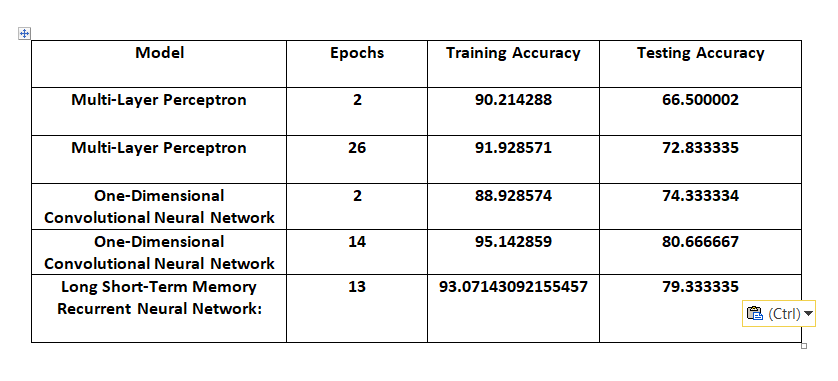